## This code will recommend games to a player using reviews each game received from each player and what games that player played the most.

We will first gather game review data from STEAM using API.

In [1]:
import requests
# Get all the games that the player played
def getownedgames(idnum):
    """Takes the id number of a steam user and returns the id num of games they own"""
    url='http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key=3A629E52AE594CB777253431189F2967&steamid={}&format=json'.format(idnum)
    r=requests.get(url)
    json_data=r.json()
    return json_data

In [2]:
def get_reviews(gameid,num):
    """Takes the id number of a game and returns 20 reviews"""
    url='http://store.steampowered.com/appreviews/{}?json=1&start_offset={} '.format(gameid,num)
    r=requests.get(url)
    json_data=r.json()
    return json_data

In [3]:
import pandas as pd
def get_all_reviews(gameid):
    """Uses 'get_review' function to pull as many reviews as it can from steam website"""
    """STEAM website usually have limitation (20 reviews) on how many reviews we can pull"""
    n=0
    stop=0
    fst_iterat=get_reviews(gameid,n)
    if fst_iterat['success']==1:
        df=pd.DataFrame(fst_iterat['reviews'])
        numreview=fst_iterat['query_summary']['num_reviews']             
        while numreview==20:
            if len(df)>=120:
                break
            n+=20
            add_iterat=get_reviews(gameid,n)
            df_add=pd.DataFrame(add_iterat['reviews'])
            df=df.append(df_add)
            numreview=add_iterat['query_summary']['num_reviews']
        df_author=pd.DataFrame(df['author'].tolist())
        df['author']=df_author['steamid']
    return df[['author','recommendationid','language','review','steam_purchase','timestamp_created','timestamp_updated']]

Get all the application id that is on STEAM website.

In [4]:
api_key='3A629E52AE594CB777253431189F2967' # API key for getting information from Steam
allgame='http://api.steampowered.com/ISteamApps/GetAppList/v0002/?key={}&format=json'.format(api_key)
all_r=requests.get(allgame)
allgame_id=all_r.json()

In [5]:
steamapp_dict=dict()
for num in range(len(allgame_id['applist']['apps'])):
    key=allgame_id['applist']['apps'][num]['appid']
    value=allgame_id['applist']['apps'][num]['name']
    if key in steamapp_dict:
        continue
    else:
        steamapp_dict[key]=value

In [6]:
len(steamapp_dict)

76626

For the sake of our code, we will use a portion of the steam apps because iterating over hundreds of reviews from 76479 apps will be very time consuming.
The games that we will be looking at was determined by looking at the ranking on metacritic.

Metacritic have their own way of determining the rankings including opinions from game reviewers, popularity from players, etc.

However, not every game from metacritic is on STEAM website and not all names are the same in these two websites.

Therefore we will use top 300 game names from metacritic and find games on STEAM that shares a part of that name(e.g. "Witcher 3" vs. "Witcher 3: Wild hunt" or "Witcher 2: Assassins of Kings")

In [7]:
top300file=open('E:\Desktop\jupyter\metacritic top 300.txt','r').read().split('\n')

to make the comparison easier, each game names will be tokenized and lower cased

In [8]:
games_names_lowered=[name.lower() for name in steamapp_dict.values()]
new_game_names=zip(games_names_lowered,steamapp_dict.values())

In [9]:
token_w_origin=list(new_game_names)

Stopwords including punctuation and version codes are removed

In [10]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

all_stops = stopwords.words('english')+list(string.punctuation)+['I','II','III','IV','V','VI','game','games']

filter out words that are included in stopwords and the words that are composed of numbers (e.g.1,2,3,4,5, ... )

In [11]:
ranked_game_list=list()
for name in top300file:
    tokens=word_tokenize(name)
    words=[word1.lower() for word1 in tokens if word1 not in all_stops]
    only_words=[word2 for word2 in words if not word2.isdigit()]
    if only_words not in ranked_game_list:
        ranked_game_list.append(only_words)

identify games that have more same tokens than the number of tokens that comprise the game name 

In [12]:
keys_of_good_games=list()
names_of_good_games=list()
for element in ranked_game_list:
    if len(element)==0:
        continue
    number_of_matched_words=len(element)
    if number_of_matched_words==0:
        number_of_matched_words=1
    for num in range(len(token_w_origin)):
        steam_game=token_w_origin[num][0].split()
        matches = {token for token in steam_game if token in element}
        if len(matches)>=number_of_matched_words:
            key=list(steamapp_dict.keys())[list(steamapp_dict.values()).index(token_w_origin[num][1])]
            keys_of_good_games.append(key)
            names_of_good_games.append(token_w_origin[num][1])
        else:
            continue

In [13]:
len(keys_of_good_games)

2693

filter out the duplicates

In [14]:
keys_of_good_games=list(set(keys_of_good_games))

In [15]:
len(keys_of_good_games)

2528

retrieve all the review data from the games that are in the list "keys_of_good_games"
This takes a while, so it should be saved as pickle

In [25]:
#pickle

for key in keys_of_good_games:
    try:
        df=get_all_reviews(key)
        print(key)
    except: 
        continue
        print('failed')
    df['game_name']=steamapp_dict.get(key)
    if 'review_df' not in locals():
        review_df=df
    else:
        review_df=review_df.append(df, ignore_index=True, sort=False)

598020
598021
598022
239350
10
622610
20
40990
41000
802860
70
729160
41050
475230
409710
409720
245890
540810
509662
210069
245910
327830
327831
270490
516250
509664
245930
598190
278710
278711
278712
245950
704710
1016010
245970
213210
220
213230
426240
213250
336140
205100
393520
295220
295221
295222
320
278850
377160
352590
426321
340
467300
221540
360
49520
213370
380
65920
24963
893320
65930
400
24980
420
41400
440
721340
721341
352710
500170
66000
66001
66002
8660
500
737800
41500
550
590380
570
287290
229950
418370
361040
8790
107100
107104
620
467570
238210
8850
660
8870
8880
8890
230090
221910
238300
238301
238302
238303
238304
254700
361220
213780
8990
9010
9030
9040
451410
9050
254820
9070
254840
17300
598940
50110
9160
287700
312290
50145
50146
50147
508910
402430
17460
877620
17470
279620
279621
279622
279623
255050
115800
50280
304240
214130
9350
345230
25800
509130
25806
25808
25809
25810
34000
25814
25815
25816
25817
771300
255220
9480
566540
222480
247080
304430
30445

C:\Users\shshi\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


264710
379400
2620
2630
404050
862810
690790
617090
617100
617110
617120
821940
617140
338620
821950
2760
273110
453360
15210
404240
650000
314160
879430
379720
322420
224140
224141
224142
224143
224144
224145
224160
224161
224162
224163
224164
224165
224166
224167
224168
691110
691120
224180
224200
371660
863180
863181
232430
437230
437231
437233
920560
920561
986100
920562
920563
920564
920567
920568
207870
560130
653530
207890
330830
568400
691280
691300
928880
879732
879733
298110
363660
421020
273570
486570
486571
273580
273590
265400
339130
273600
273620
249081
249082
249083
249085
249086
249087
249088
249090
249092
249094
314680
44350
208200
44360
249180
249181
216420
216421
404860
429450
339340
495030
19900
413150
683490
593380
617960
617961
617962
282090
282091
282092
224760
552450
216610
355880
247299
44600
486970
323130
323140
552520
323170
323180
208500
355960
822910
806530
790170
323230
519860
618170
241364
241368
241369
241370
642780
241371
241372
298720
913120
487150
383

In [16]:
import pickle

In [24]:
#fileObject=open(file_name,'wb')

In [25]:
#pickle.dump(review_df,fileObject)

In [26]:
#fileObject.close()

Now that we have the database to get games from, we will test it with a player.

In [17]:
test_id=76561198070249881

In [19]:
file_name='testfile'

In [20]:
review_df=pickle.load(open(file_name,"rb"))

In [21]:
review_df.head(10)

,author,recommendationid,language,review,steam_purchase,timestamp_created,timestamp_updated,game_name
0,76561198116100475,49214617,english,A little biased as I got this for 'free' with ...,True,1551026300,1551026424,"Mafia III: Faster, Baby!"
1,76561198116100475,49334938,english,On a sale - HELLA YES!\nWithout a discount - N...,True,1551614792,1551614792,Mafia III: Stones Unturned
2,76561198116100475,49301576,english,Why isn't the Main Game like this DLC?\nAbsolu...,True,1551470571,1551470571,Mafia III: Sign of the Times
3,76561198821796334,49358363,english,Pretty fucking hard but very cool game!,True,1551720577,1551720577,Spelunky
4,76561198133963882,49386129,english,"I don't even play many platformers, but I stil...",True,1551833236,1551833236,Spelunky
5,76561198043141890,49283358,english,Just one... more... horribly... brutal... deat...,True,1551380309,1551380309,Spelunky
6,76561198063251252,49264539,english,Its hard.,True,1551282914,1551282914,Spelunky
7,76561198058640737,49079132,english,★★★★★\n\nWhip arrows,True,1550520690,1550520690,Spelunky
8,76561198836750310,49150591,english,Don't think about graphics. Still it's so much...,True,1550819202,1550819202,Counter-Strike
9,76561198849360285,49434533,english,Old but Gold,True,1552058322,1552058322,Counter-Strike


In [69]:
from langdetect import detect

In [70]:
from langdetect import DetectorFactory 
DetectorFactory.seed = 0

In [71]:
lang=list()
for num in range(len(review_df['review'])):
    try: 
        detected=detect(review_df['review'][num])
        lang.append(detected)
    except:
        lang.append('NaN')

In [73]:
review_df['detected_lang']=lang
review_df=review_df[review_df['detected_lang']=='en']

Define function to take all the review data into documents; one review document from each game

In [74]:
def amalgamate(df):
    dumped_dict=dict()
    for name in df['game_name'].unique():
        dump=df.loc[(df['game_name']==name)]['review'].sum(axis=0)
        dumped_dict[name]=dump
    return dumped_dict

In [75]:
allgamedatabase=amalgamate(review_df)

save the game data of a player in the variable: testperson
extract the game ids and the time the player spent on each game: testids, testplaytimes

In [76]:
testperson=getownedgames(test_id)['response']['games']

In [77]:
testperson

[{'appid': 4000, 'playtime_forever': 432},
 {'appid': 22330, 'playtime_forever': 1307},
 {'appid': 6060, 'playtime_forever': 94},
 {'appid': 6000, 'playtime_forever': 37},
 {'appid': 32370, 'playtime_forever': 1194},
 {'appid': 12830, 'playtime_forever': 1},
 {'appid': 39540, 'playtime_forever': 21},
 {'appid': 550, 'playtime_forever': 446},
 {'appid': 22370, 'playtime_forever': 751},
 {'appid': 33910, 'playtime_forever': 648},
 {'appid': 33930, 'playtime_forever': 28},
 {'appid': 219540, 'playtime_forever': 0},
 {'appid': 8930, 'playtime_forever': 1130},
 {'appid': 39500, 'playtime_forever': 0},
 {'appid': 39510, 'playtime_forever': 0},
 {'appid': 65540, 'playtime_forever': 2},
 {'appid': 47810, 'playtime_forever': 3225},
 {'appid': 20920, 'playtime_forever': 1397},
 {'appid': 65800, 'playtime_forever': 365},
 {'appid': 22380, 'playtime_forever': 2487},
 {'appid': 104900, 'playtime_forever': 350},
 {'appid': 91310, 'playtime_forever': 20},
 {'appid': 211420, 'playtime_forever': 847},


In [78]:
testids=list()
testplaytimes=list()
for i in range(len(testperson)):
    testids.append(testperson[i]['appid'])
    testplaytimes.append(testperson[i]['playtime_forever'])

select the games that are present in the database we set up for this analysis and make a new dataframe comprised of playtime and game ids: test_df

In [79]:
available_game_id_list=list()
for num in range(len(testperson)):
    appids=testperson[num]['appid']
    if appids in keys_of_good_games:
        available_game_id_list.append(appids)

In [80]:
newplaytime=list()
for ids in available_game_id_list:
    element=testids.index(ids)
    newplaytime.append(testplaytimes[element])
test_df=pd.DataFrame(list(zip(gameidlist,newplaytime)),columns=['ids','playtime']).sort_values('playtime',ascending=False)

In [81]:
test_df.head()

,ids,playtime
7,72850,13900
15,292030,9524
21,377160,8836
5,200710,2284
23,268500,2069


pick the top 15 most played game in the list and retreive all the reviews that are present there : player_df

In [94]:
top15playedgame_id=test_df_2[0:14]['ids'].tolist()

In [95]:
top15playedgame_id

[72850,
 292030,
 377160,
 200710,
 268500,
 49520,
 298110,
 271590,
 413150,
 20920,
 22330,
 206420,
 8870,
 287700]

In [96]:
top15playedgame_name=list()
for id in top15playedgame_id:
    name=steamapp_dict.get(id)
    top15playedgame_name.append(name)

In [97]:
top15playedgame_name

['The Elder Scrolls V: Skyrim',
 'The Witcher 3: Wild Hunt',
 'Fallout 4',
 'Torchlight II',
 'XCOM 2',
 'Borderlands 2',
 'Far Cry 4',
 'Grand Theft Auto V',
 'Stardew Valley',
 'The Witcher 2: Assassins of Kings Enhanced Edition',
 'The Elder Scrolls IV: Oblivion ',
 'Saints Row IV',
 'BioShock Infinite',
 'METAL GEAR SOLID V: THE PHANTOM PAIN']

In [105]:
for id in top15playedgame:
    df=get_all_reviews(id)
    df['game_name']=steamapp_dict.get(id)
    if 'player_df' not in locals():
        player_df=df
    else:
        player_df=player_df.append(df, ignore_index=True, sort=False)

In [106]:
player_df.head()

,author,recommendationid,language,review,steam_purchase,timestamp_created,timestamp_updated,game_name
0,76561198108422433,49216927,english,DLC Page\n-------------\n\nhttps://store.steam...,True,1551033986,1552527148,The Elder Scrolls V: Skyrim
1,76561198074610624,49395835,english,DLC Page\n-------------\n\nhttps://store.steam...,True,1551882372,1551882372,The Elder Scrolls V: Skyrim
2,76561198313601265,49327139,english,"Great game, horrible publisher. Really wish Be...",True,1551580578,1551580578,The Elder Scrolls V: Skyrim
3,76561198071642858,49253936,english,dirty dirty trick Bethesda. hiding the dlc for...,True,1551224313,1551224313,The Elder Scrolls V: Skyrim
4,76561198122616211,49603949,english,Bethesda gay but Skyrim good,True,1552785967,1552785967,The Elder Scrolls V: Skyrim


In [107]:
player_dict=amalgamate(player_df)

In [108]:
for_analysis={**allgamedatabase,**player_dict}

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk.stem

In [88]:
import re
stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

vectorizer_s = StemmedCountVectorizer(analyzer="word", stop_words=all_stops,ngram_range=(1,2),min_df=0.01,token_pattern=r'\b[^\d\W]+\b')

In [89]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

tfidf_s = StemmedTfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word', stop_words=all_stops,ngram_range=(1,2),min_df=0.01,token_pattern=r'\b[^\d\W]+\b')

In [90]:
def stemvect(text):
    X=vectorizer_s.fit_transform(text)
    return X.toarray(), vectorizer_s.get_feature_names()

In [91]:
def stemtfidf(text):
    X=tfidf_s.fit_transform(text)
    return X.toarray(),tfidf_s.get_feature_names()

In [109]:
freq,words=stemvect(for_analysis.values())
tdfscore,tdfwords=stemtfidf(for_analysis.values())

In [110]:
games_tdf=pd.DataFrame(tdfscore,index=for_analysis.keys(),columns=tdfwords)

In [111]:
games_tdf.head()

,aaa,abandon,abil,abl,able get,able play,absolut,absolutely lov,absolutely noth,absurd,...,young,younger,your,youtu,youtub,youtube com,zero,zombi,zone,zoom
"Mafia III: Faster, Baby!",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mafia III: Stones Unturned,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mafia III: Sign of the Times,0.0,0.0,0.0,0.0,0.0,0.0,2.816388,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spelunky,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Counter-Strike,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,4.887986,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
list_of_games=games_tdf.index.tolist()
listlength=len(list_of_games)
import numpy as np
from scipy import spatial
matrixforgame=np.zeros(shape=(listlength,listlength))
for i in range(len(list_of_games)):
    game=list_of_games[i]
    for j in range(len(list_of_games)):
        another=list_of_games[j]
        if game!=another:
            result=1-spatial.distance.cosine(games_tdf.loc[game].values,games_tdf.loc[another].values)
            matrixforgame[i][j]=result

C:\Users\shshi\Anaconda3\lib\site-packages\scipy\spatial\distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [113]:
result_df=pd.DataFrame(matrixforgame,index=list_of_games,columns=list_of_games)

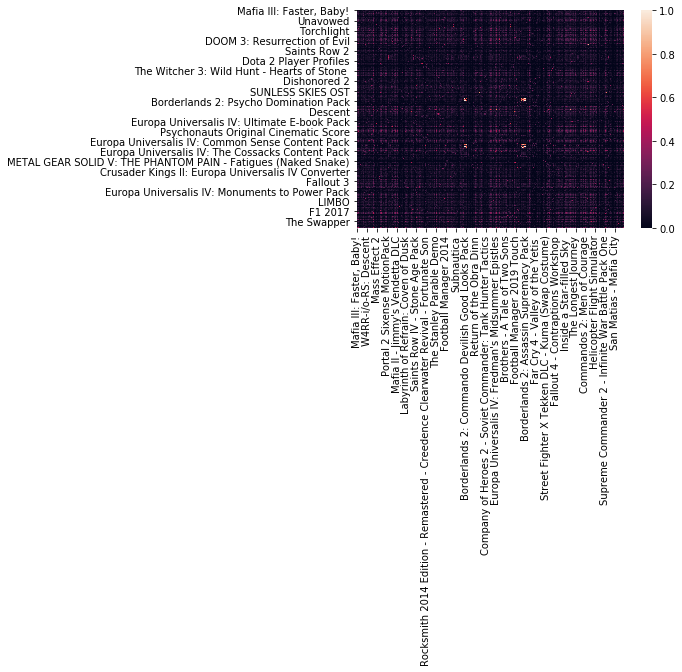

In [114]:
import seaborn as sns
sns.heatmap(result_df)

In [115]:
weight=len(list(player_dict.keys()))
result_df['total'] = 0
for name in player_df['game_name'].unique():
    result_df['total']=result_df['total']+(weight*result_df[name])
    weight=weight-1

In [116]:
print(result_df['total'].sort_values(ascending=False))

Far Cry 5                                                                                  42.535944
Rise of the Tomb Raider                                                                    41.631365
Subnautica                                                                                 38.828686
Undertale                                                                                  37.967631
RimWorld                                                                                   37.940739
The Elder Scrolls V: Skyrim Special Edition                                                37.325074
Hellblade: Senua's Sacrifice                                                               36.870092
Hollow Knight                                                                              36.590875
Borderlands 2                                                                              36.330572
Night in the Woods                                                                         

In [25]:
type(dftestttt['steamid'])

pandas.core.series.Series

In [182]:

stop=0
while stop==0:
    print(numreview)
    stop-=1

0


In [169]:
df=pd.DataFrame(get_reviews(gameid,0)['reviews'])
df2=pd.DataFrame(get_reviews(gameid,30)['reviews'])

In [174]:
df2

,author,comment_count,developer_response,language,received_for_free,recommendationid,review,steam_purchase,timestamp_created,timestamp_dev_responded,timestamp_updated,voted_up,votes_funny,votes_up,weighted_vote_score,written_during_early_access
0,"{'steamid': '76561198007701391', 'num_games_ow...",0,NaN,english,False,47862873,Ok so had this game 5 hours and 20 minutes ......,True,1545910879,NaN,1545910879,True,0,26,0.712041854858398438,True
1,"{'steamid': '76561198020320520', 'num_games_ow...",0,NaN,english,False,49263225,"Pretty good. This is a far more ""serious"" hack...",True,1551277384,NaN,1551277384,True,0,13,0.686274528503417969,False
2,"{'steamid': '76561198213662115', 'num_games_ow...",0,NaN,english,False,48047130,"Ok, so I know what every other revew for this ...",True,1546450279,NaN,1546450279,True,0,11,0.672005772590637207,True
3,"{'steamid': '76561197992905965', 'num_games_ow...",0,NaN,english,False,48913975,I'm shocked at how much work went into this ga...,True,1549840777,NaN,1549840777,True,0,11,0.633472859859466553,True
4,"{'steamid': '76561198335320044', 'num_games_ow...",0,NaN,english,False,48934813,[h1]Why I love this game[/h1]\nI always liked ...,True,1549917364,NaN,1549917438,True,0,7,0.625,True
5,"{'steamid': '76561198037909820', 'num_games_ow...",0,NaN,english,False,49270205,Polished and well presented game! spent a coup...,True,1551311794,NaN,1551311794,True,0,4,0.558327972888946533,False
6,"{'steamid': '76561198052842298', 'num_games_ow...",2,Really sorry you did not enjoy my games! Once ...,english,False,48890306,[h1] I really wanted to like this game [/h1]\n...,True,1549771541,0.0,1549774290,False,0,7,0.622579872608184814,True
7,"{'steamid': '76561197980716385', 'num_games_ow...",0,NaN,english,False,47765970,"The game is a blast, for someone in cyber secu...",True,1545619152,NaN,1545619152,True,1,3,0.550561785697937012,True
8,"{'steamid': '76561197967326997', 'num_games_ow...",0,NaN,english,False,48913327,Really awesome hacking simulator!,True,1549838030,NaN,1549838030,True,0,3,0.523809552192687988,True
9,"{'steamid': '76561198043136194', 'num_games_ow...",0,NaN,english,False,49271830,I had no idea...\nA couple of hours into the g...,True,1551323025,NaN,1551323025,True,0,3,0.542483627796173096,False


In [170]:
df3=df.append(df2)

In [171]:
df3

,author,comment_count,developer_response,language,received_for_free,recommendationid,review,steam_purchase,timestamp_created,timestamp_dev_responded,timestamp_updated,voted_up,votes_funny,votes_up,weighted_vote_score,written_during_early_access
0,"{'steamid': '76561198020320520', 'num_games_ow...",0,NaN,english,False,49263225,"Pretty good. This is a far more ""serious"" hack...",True,1551277384,NaN,1551277384,True,0,13,0.686274528503417969,False
1,"{'steamid': '76561197992905965', 'num_games_ow...",0,NaN,english,False,48913975,I'm shocked at how much work went into this ga...,True,1549840777,NaN,1549840777,True,0,11,0.633472859859466553,True
2,"{'steamid': '76561198335320044', 'num_games_ow...",0,NaN,english,False,48934813,[h1]Why I love this game[/h1]\nI always liked ...,True,1549917364,NaN,1549917438,True,0,7,0.625,True
3,"{'steamid': '76561198037909820', 'num_games_ow...",0,NaN,english,False,49270205,Polished and well presented game! spent a coup...,True,1551311794,NaN,1551311794,True,0,4,0.558327972888946533,False
4,"{'steamid': '76561198052842298', 'num_games_ow...",2,Really sorry you did not enjoy my games! Once ...,english,False,48890306,[h1] I really wanted to like this game [/h1]\n...,True,1549771541,0.0,1549774290,False,0,7,0.622579872608184814,True
5,"{'steamid': '76561197967326997', 'num_games_ow...",0,NaN,english,False,48913327,Really awesome hacking simulator!,True,1549838030,NaN,1549838030,True,0,3,0.523809552192687988,True
6,"{'steamid': '76561198043136194', 'num_games_ow...",0,NaN,english,False,49271830,I had no idea...\nA couple of hours into the g...,True,1551323025,NaN,1551323025,True,0,3,0.542483627796173096,False
7,"{'steamid': '76561198070387804', 'num_games_ow...",0,NaN,english,False,48688300,"I love this game, we need more of this games:D",True,1549023283,NaN,1549023283,True,0,2,0,True
8,"{'steamid': '76561197977665745', 'num_games_ow...",0,NaN,english,False,48916012,I adore hacking games and this one is really g...,True,1549851211,NaN,1549851211,True,0,2,0.523809552192687988,True
9,"{'steamid': '76561198062003857', 'num_games_ow...",0,NaN,english,False,49255705,If you like Hacknet this is definitly worthy g...,True,1551234902,NaN,1551235821,True,0,2,0.525862038135528564,False


In [159]:
recomd=df['recommendationid'].tolist()
recomd2=df2['recommendationid'].tolist()
print(recomd)
print(recomd2)

['49263225', '48913975', '48934813', '49270205', '48890306', '48913327', '49271830', '48688300', '48916012', '49255705', '49257866', '49230384', '48918511', '48957687', '49281613', '49268071', '49057388', '49077232', '49182083', '49265740']
['47862873', '49263225', '48047130', '48913975', '48934813', '49270205', '48890306', '47765970', '48913327', '49271830', '48340242', '48688300', '48916012', '49255705', '49257866', '48135407', '49230384', '47778714', '47859188', '47719697']


In [158]:
len(set(recomd)&set(recomd2))

12

In [120]:
pd.DataFrame(df['reviews'])['recommendationid'].tolist()

['49270433',
 '48976432',
 '49255666',
 '49268215',
 '49040328',
 '49101451',
 '49281613',
 '48829686']

In [ ]:
n=0
stop=0
fst_iterat=get_reviews(gameid,n)
if fst_iterat['success']==1:
    df=pd.DataFrame(fst_iterat['reviews'])
    numreview=fst_iterat['query_summary']['num_reviews']    
    while stop==0:
        if numreview!=20:
            stop=1
        else:
            n=n+20
        add_iterat=get_reviews(gameid,n)
        numreview=add_iterat['query_summary']['num_reviews']
        add_iterat=get_reviews(gameid,n)
        df2=pd.DataFrame(add_iterat['reviews'])
        df.append(df2)

In [89]:
get_all_reviews(gameid)

,author,comment_count,developer_response,language,received_for_free,recommendationid,review,steam_purchase,timestamp_created,timestamp_dev_responded,timestamp_updated,voted_up,votes_funny,votes_up,weighted_vote_score,written_during_early_access
0,"{'steamid': '76561198020320520', 'num_games_ow...",0,NaN,english,False,49263225,"Pretty good. This is a far more ""serious"" hack...",True,1551277384,NaN,1551277384,True,0,11,0.665271997451782227,False
1,"{'steamid': '76561197992905965', 'num_games_ow...",0,NaN,english,False,48913975,I'm shocked at how much work went into this ga...,True,1549840777,NaN,1549840777,True,0,11,0.633472859859466553,True
2,"{'steamid': '76561198335320044', 'num_games_ow...",0,NaN,english,False,48934813,[h1]Why I love this game[/h1]\nI always liked ...,True,1549917364,NaN,1549917438,True,0,7,0.625,True
3,"{'steamid': '76561198037909820', 'num_games_ow...",0,NaN,english,False,49270205,Polished and well presented game! spent a coup...,True,1551311794,NaN,1551311794,True,0,4,0.558327972888946533,False
4,"{'steamid': '76561198052842298', 'num_games_ow...",2,Really sorry you did not enjoy my games! Once ...,english,False,48890306,[h1] I really wanted to like this game [/h1]\n...,True,1549771541,0.0,1549774290,False,0,7,0.622579872608184814,True
5,"{'steamid': '76561197967326997', 'num_games_ow...",0,NaN,english,False,48913327,Really awesome hacking simulator!,True,1549838030,NaN,1549838030,True,0,3,0.523809552192687988,True
6,"{'steamid': '76561198043136194', 'num_games_ow...",0,NaN,english,False,49271830,I had no idea...\nA couple of hours into the g...,True,1551323025,NaN,1551323025,True,0,3,0.542483627796173096,False
7,"{'steamid': '76561198070387804', 'num_games_ow...",0,NaN,english,False,48688300,"I love this game, we need more of this games:D",True,1549023283,NaN,1549023283,True,0,2,0,True
8,"{'steamid': '76561197977665745', 'num_games_ow...",0,NaN,english,False,48916012,I adore hacking games and this one is really g...,True,1549851211,NaN,1549851211,True,0,2,0.523809552192687988,True
9,"{'steamid': '76561198062003857', 'num_games_ow...",0,NaN,english,False,49255705,If you like Hacknet this is definitly worthy g...,True,1551234902,NaN,1551235821,True,0,2,0.525862038135528564,False
